In [1]:
# import ee
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

import rasterio
import geopandas as gpd
import datetime
import pandas as pd


In [2]:
def collect_responses(url, info = ["code"]):
    data = {"links": [{"rel": "next", "href": url}]}
    output = list()
    while "next" in [x["rel"] for x in data["links"]]:
        url_ = [x["href"] for x in data["links"] if x["rel"] == "next"][0]
        response = requests.get(url_)
        response.raise_for_status()
        data = response.json()["response"]
        if isinstance(info, list):
            output += [tuple(x.get(y) for y in info) for x in data["items"]]
        else:
            output += data["items"]
    if isinstance(info, list):
        output = sorted(output)
    return output

In [3]:
coords =[
    (30.922492,31.096858),
    (30.956333,28.912028)
]
sites = sites = [['Sakha','Sids']]

**NOTES**

For L3, coordinates in lon, lat need to be converted to the CRS of the raster. For that EPSG code of L3 raster is needed

In [11]:
import utm

def convert_to_utm(lat, lon):
    # Convert latitude and longitude to UTM coordinates
    utm_coords = utm.from_latlon(lat, lon)
    return utm_coords

utm_coords = []
# Example coordinates (latitude, longitude)
for coord in coords:
    latitude = coord[1]
    longitude = coord[0]

    # Convert to UTM zone 36N
    y,x,_,_ = utm.from_latlon(latitude, longitude)
    utm_coords.append((x,y))
    
print(utm_coords)

[(np.float64(3442192.2545627938), np.float64(301848.83360569156)), (np.float64(3199957.5460200873), np.float64(300756.00191389554))]


In [24]:
from pyproj import Proj, transform

def convert_to_epsg32636(lat, lon):
    # Define the projection for EPSG:4326 (WGS84) and EPSG:32636 (UTM zone 36N)
    proj_wgs84 = Proj(init='epsg:4326')
    proj_utm36n = Proj(init='epsg:32636')
    
    # Convert latitude and longitude to UTM coordinates
    utm_x, utm_y = transform(proj_wgs84, proj_utm36n, lon, lat)
    
    return utm_x, utm_y
utm_coords = []
# Example coordinates (latitude, longitude)
for coord in coords:
    latitude = coord[1]
    longitude = coord[0]

    # Convert to UTM zone 36N
    x,y = convert_to_epsg32636(latitude, longitude)
    utm_coords.append((x,y))
    

print(f"Coordinates in EPSG:32636: {utm_coords}")

Coordinates in EPSG:32636: [(301848.833609607, 3442192.2545584594), (300756.00191700726, 3199957.546026331)]


C:\Users\ntr002\.conda\envs\phd\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\ntr002\.conda\envs\phd\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\ntr002\AppData\Local\Temp\ipykernel_9764\4198822676.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
 

# Extract point time-series

In [5]:
#get list of L3 rasters
mapset_code = "L3-AETI-D"
base_url = f"https://data.apps.fao.org/gismgr/api/v2/catalog/workspaces/WAPOR-3/mosaicsets"
mapset_url = f"{base_url}/{mapset_code}/rasters"
all_rasters = collect_responses(mapset_url, info = ["code", "downloadUrl"])
raster_urls = [i[1] for i in all_rasters]
raster_urls

['https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.AWA.2018-01-D1.tif',
 'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.AWA.2018-01-D2.tif',
 'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.AWA.2018-01-D3.tif',
 'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.AWA.2018-02-D1.tif',
 'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.AWA.2018-02-D2.tif',
 'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.AWA.2018-02-D3.tif',
 'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.AWA.2018-03-D1.tif',
 'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3

In [25]:
coords= utm_coords #use utm coords instead of longitude, latitude
L3_code = 'ENO' #Egypt North
# Downlaod time series data 
scale = 0.1 #conversion factor from integer to float
urls = raster_urls # chose raster from which you want to downlaod the pixel data 
pt_data = []
dates = []
dekad_day = {
   'D1':'01',
    'D2': '11',
    'D3': '21'    
}

for url in urls:
    if L3_code in url:
        date = pd.to_datetime(url[-14:-6]+dekad_day[url[-6:-4]]) 
        dates.append(date)
        # Open the raster and store metadata
        print(url)
        src = rasterio.open(url)    
        # Sample the raster at every point location and store values in DataFrame
        pt = [x[0] for x in src.sample(coords)]
        pt_data.append(pt)
    else:
        continue
    
# convert the data to adataframe
df = pd.DataFrame(pt_data, columns=sites, index = dates)
df = df*scale
df.to_csv('Sakha_sids_sse_points_L3.csv')


https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.ENO.2018-01-D1.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.ENO.2018-01-D2.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.ENO.2018-01-D3.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.ENO.2018-02-D1.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.ENO.2018-02-D2.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.ENO.2018-02-D3.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.ENO.2018-03-D1.tif
https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MOSAICSET/L3-AETI-D/WAPOR-3.L3-AETI-D.ENO.2018-03-D2.tif


In [26]:
df

,Sakha,Sids
2018-01-01,0.8,1.3
2018-01-11,1.0,1.5
2018-01-21,1.0,1.7
2018-02-01,1.7,2.7
2018-02-11,1.5,2.5
...,...,...
2024-12-01,0.6,1.4
2024-12-11,0.4,1.7
2024-12-21,0.5,1.6
2025-01-01,0.6,2.2


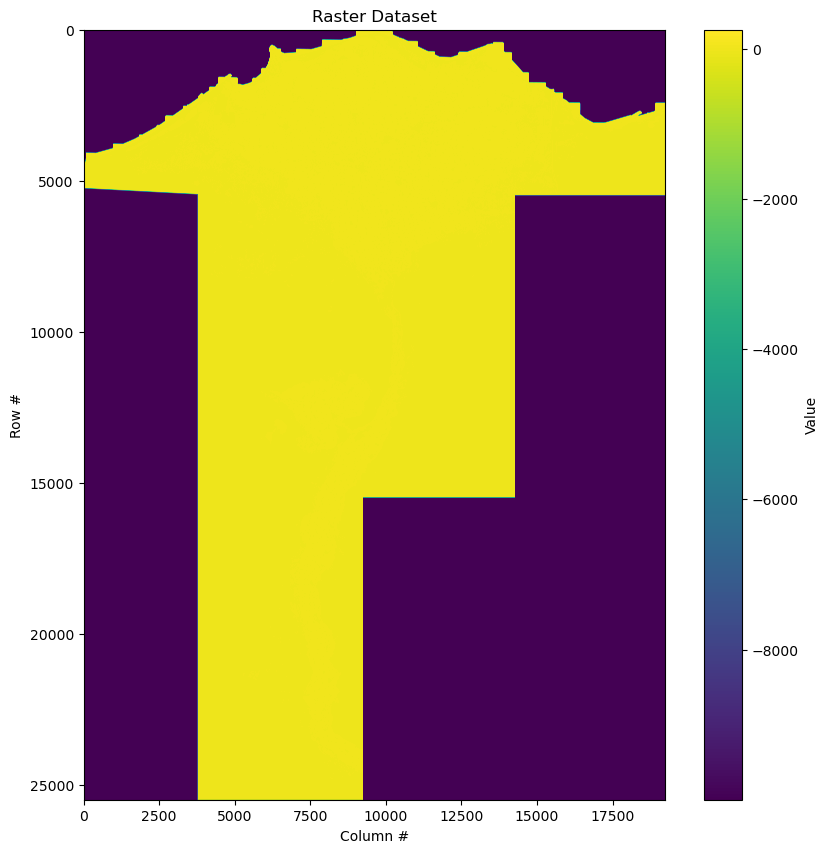

In [14]:
# Read the first band of the dataset
band1 = src.read(1)

# Plot the raster dataset
plt.figure(figsize=(10, 10))
plt.imshow(band1, cmap='viridis')
plt.colorbar(label='Value')
plt.title('Raster Dataset')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

In [15]:
# List all the bands in the dataset
bands = src.indexes

# Print the geographical references and coordinates
crs = src.crs
transform = src.transform

print(f"The dataset contains the following bands: {bands}")
print(f"Coordinate Reference System: {crs}")
print(f"Affine Transformation: {transform}")

# Print the bounding box coordinates
bbox = src.bounds
print(f"Bounding Box Coordinates: {bbox}")

The dataset contains the following bands: (1,)
Coordinate Reference System: EPSG:32636
Affine Transformation: | 20.00, 0.00, 124920.00|
| 0.00,-20.00, 3499880.00|
| 0.00, 0.00, 1.00|
Bounding Box Coordinates: BoundingBox(left=124920.0, bottom=2990300.0, right=509620.0, top=3499880.0)
